<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

### Инструкция по выполнению проекта:  

Шаг 1. Загрузите данные и проведите исследовательский анализ данных.  
Скачайте  и откройте файлы с данными. Проверьте данные и откорректируйте их, если потребуется.  

Шаг 2. Подготовьте данные к обучению модели.  
- Создайте список слов которые, по вашему мнению, могут попадать под юридические ограничения.  
- Исключите из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения.  
- Сделайте векторизацию текстового описания одним из следующих методов:  
  - TF-IDF;  
  - BERT;  
  - word2vec.  
- Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.  
- Дайте описание получившихся пар векторов с точки зрения их размерностей.  

Шаг 3. Обучите модель.  
- Создайте модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.  
- Выберите метрику, по которой вы будете сравнивать точность различных моделей.  
- Обучите несколько моделей и подберите их гиперпараметры. В качестве моделей обязательно нужно рассмотреть:  
  1. Линейную регрессию;  
  2. Полносвязные нейронные сети.  

Шаг 4. Тестирование модели и демонстрация ее работы.  
- Проведите тестирование лучшей модели на тестовых данных.  
- Напишите функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики. Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.  
- С помощью написанной вами функции протестируйте работу модели на нескольких текстовых описаниях: проверьте, какие картинки она выдает при различных текстовых запросах.  

Шаг 5. Сделайте общий вывод по работе.  

**Импорт библиотек**

In [1]:
#%pip install --upgrade pip==24.0

In [4]:
#%pip install keras-nlp

In [5]:
#%pip install tensorflow

In [3]:
#%pip install sentence-transformers

In [6]:
# Импортируем необходимые библиотеки
import os
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import nltk
import keras_nlp
import sentence_transformers
import glob
import pickle
import tensorflow as tf


from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()
from PIL import Image
from pathlib import Path
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error, mean_absolute_error
#from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sentence_transformers import SentenceTransformer, util
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from statistics import mode

nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

2024-04-10 10:24:46.604914: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 10:24:46.610383: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 10:24:46.856750: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 10:24:47.817562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 10:24:50.312667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

True

In [3]:
# Объявим глобальные переменные
DATA_PATH = '/home/jupyter/datasphere/project/'
SEED = 12345
BLOCK = ['baby', 'child', 'teenager', 'girl', 'boy', 'kid']
#BLOCK = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant', 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', 'teenagers']

In [8]:
# Загрузим данные в датафреймы, в df_crowd и df_expert переименуем столбцы
df_train = pd.read_csv(Path(DATA_PATH, 'train_dataset.csv'))
df_crowd = pd.read_csv(Path(DATA_PATH, 'CrowdAnnotations.tsv'), sep = '\t', names = ['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
df_expert = pd.read_csv(Path(DATA_PATH, 'ExpertAnnotations.tsv'), sep = '\t', names = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
df_queries = pd.read_csv(Path(DATA_PATH, 'test_queries.csv'), index_col = [0], sep = '|')
df_images = pd.read_csv(Path(DATA_PATH, 'test_images.csv'), sep = '|')

Загрузка данных прошла успешно, посмотрим на структуру датафреймов и параметры их данных.

**train_dataset.csv**

In [9]:
df_train.head()

image  ...                                         query_text
0  1056338697_4f7d7ce270.jpg  ...  A young child is wearing blue goggles and sitt...
1  1262583859_653f1469a9.jpg  ...  A young child is wearing blue goggles and sitt...
2  2447284966_d6bbdb4b6e.jpg  ...  A young child is wearing blue goggles and sitt...
3  2549968784_39bfbe44f9.jpg  ...  A young child is wearing blue goggles and sitt...
4  2621415349_ef1a7e73be.jpg  ...  A young child is wearing blue goggles and sitt...

[5 rows x 3 columns]

In [10]:
df_train.describe()

image  ...                                         query_text
count                        5822  ...                                               5822
unique                       1000  ...                                                977
top     3107513635_fe8a21f148.jpg  ...  Two dogs , one brown and white and one black a...
freq                           10  ...                                                 34

[4 rows x 3 columns]

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [12]:
df_train.duplicated().sum()

0

Количество объектов в датафрейме df_train - 5822;  
Количество уникальных изображений в датафрейме df_train - 1000;  
Количество уникальных значений в столбце 'query_id- - 977;  
Количество уникальных значений в столбце 'query_text- - 977;  
Количество пропущенных значений - 0;  
Количество явных дубликатов - 0.  

Found 5822 validated image filenames.


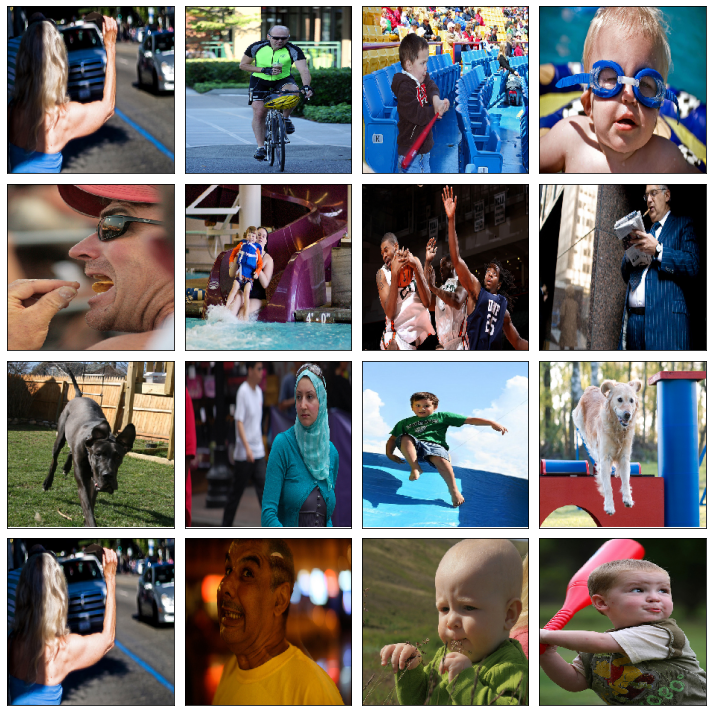

In [13]:
# Посмотрим на изображения, входяще в тренировочный датасет.

# Создадим загрузчик
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = Path(DATA_PATH, 'train_images'),
    x_col = 'image',
    y_col = 'final_mark',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'input',
    seed = SEED,
    shuffle = False)

features, target = next(train_gen_flow)

# Выведем на экран
fig = plt.figure(figsize = (10,10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

**CrowdAnnotations.tsv**

In [14]:
df_crowd.head()

image                     query_id  ...  count_pos  count_neg
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  ...          3          0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  ...          0          3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  ...          0          3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  ...          0          3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  ...          0          3

[5 rows x 5 columns]

In [15]:
df_crowd.describe()

share_pos     count_pos     count_neg
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

In [16]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [17]:
df_crowd.duplicated().sum()

0

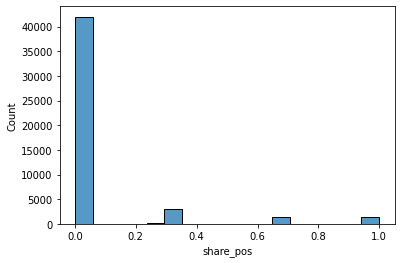

In [18]:
# Посмотрим графически на доли людей, подтвердивших, что описание соответствует изображению (по балльной оценке 1-4)
sns.histplot(df_crowd['share_pos']);

Количество объектов в датафрейме df_crowd - 47830;    
Среднее количество проголосовавших за соответствие в разы ниже, чем тех, кто проголосовал за несоответствие;  
Медианное количество оценок для подтвердивших соответствие - 0;  
Медианное количество оценок для подтвердивших несоответствие - 3;  
На краудсорсинге чаще дают отрицательный ответ (подтверждено графически);  
Количество пропущенных значений - 0;  
Количество явных дубликатов - 0.  

**ExpertAnnotations.tsv**

In [19]:
df_expert.head()

image                     query_id  ...  expert_2  expert_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  ...         1         1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  ...         1         2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  ...         1         2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  ...         2         2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  ...         1         2

[5 rows x 5 columns]

In [20]:
df_expert.describe()

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

In [21]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [22]:
df_expert.duplicated().sum()

0

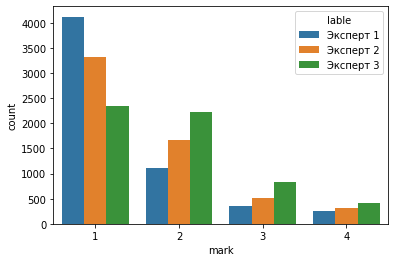

In [23]:
# Посмотрим графически на соотношение оценок, данных 3-мя экспертами
df_exp_1 = pd.DataFrame(columns = [ 'mark' , 'lable' ])
df_exp_2 = pd.DataFrame(columns = [ 'mark' , 'lable' ])
df_exp_3 = pd.DataFrame(columns = [ 'mark' , 'lable' ])

df_exp_1['mark'] = df_expert['expert_1']
df_exp_1['lable'] = 'Эксперт 1'
df_exp_2['mark'] = df_expert['expert_2']
df_exp_2['lable'] = 'Эксперт 2'
df_exp_3['mark'] = df_expert['expert_3']
df_exp_3['lable'] = 'Эксперт 3'

for_plot = pd.concat([df_exp_1, df_exp_2, df_exp_3])

sns.countplot(data = for_plot, x = 'mark', hue = 'lable');

Количество объектов в датафрейме df_expert - 5822;    
Среднее значение голоса эксперта 1 - 1.436;  
Среднее значение голоса эксперта 2 - 1.624;  
Среднее значение голоса эксперта 3 - 1.882;   
Медианное значение голоса эксперта 1 - 1;  
Медианное значение голоса эксперта 2 - 1;  
Медианное значение голоса эксперта 3 - 2;   
Количество пропущенных значений - 0;  
Количество явных дубликатов - 0.  

**test_queries.csv**

In [24]:
df_queries.head()

query_id  ...                      image
0  1177994172_10d143cb8d.jpg#0  ...  1177994172_10d143cb8d.jpg
1  1177994172_10d143cb8d.jpg#1  ...  1177994172_10d143cb8d.jpg
2  1177994172_10d143cb8d.jpg#2  ...  1177994172_10d143cb8d.jpg
3  1177994172_10d143cb8d.jpg#3  ...  1177994172_10d143cb8d.jpg
4  1177994172_10d143cb8d.jpg#4  ...  1177994172_10d143cb8d.jpg

[5 rows x 3 columns]

In [25]:
df_queries.describe()

query_id  ...                     image
count                          500  ...                       500
unique                         500  ...                       100
top     989851184_9ef368e520.jpg#4  ...  989851184_9ef368e520.jpg
freq                             1  ...                         5

[4 rows x 3 columns]

In [26]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [27]:
df_queries.duplicated().sum()

0

Количество объектов в датафрейме df_queries - 500;  
Количество уникальных изображений в датафрейме df_queries - 100;  
Количество уникальных значений в столбце 'query_id- - 500;  
Количество уникальных значений в столбце 'query_text- - 500;  
Количество пропущенных значений - 0;  
Количество явных дубликатов - 0.  

**test_images.csv**

In [28]:
df_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [29]:
df_images.describe()

image
count                         100
unique                        100
top     2346402952_e47d0065b6.jpg
freq                            1

In [30]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [31]:
df_images.duplicated().sum()

0

Found 100 validated image filenames.


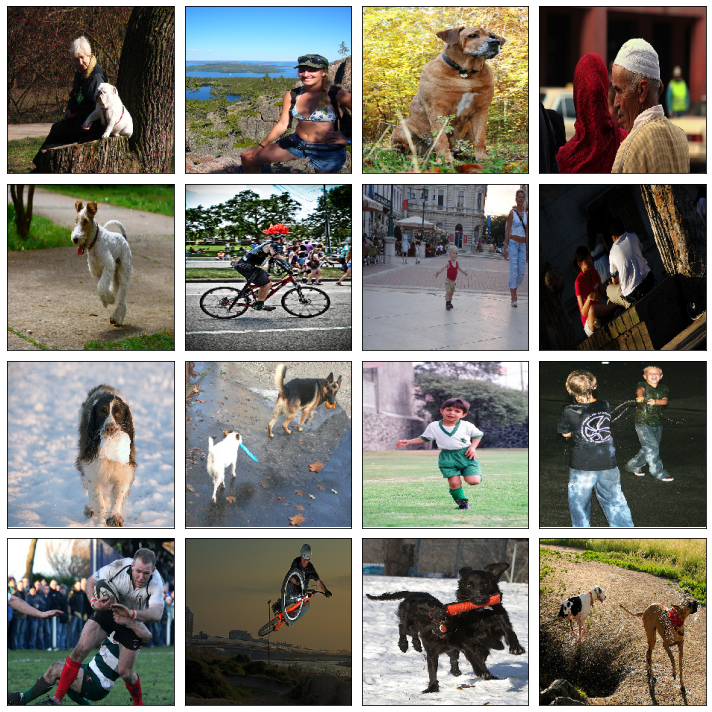

In [32]:
# Познакомимся с изображениями, входящими в тестовый датасет.

test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe = df_images,
    directory = Path(DATA_PATH, 'test_images'),
    x_col ='image',
    y_col = None,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'input',
    seed = SEED,
    shaffle = False)

features, target = next(test_gen_flow)

# Выведем на экран
fig = plt.figure(figsize = (10,10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Количество объектов в датафрейме df_images - 100;  
Количество уникальных объектов в датафрейме df_images - 100;  
Количество пропущенных значений - 0;  
Количество явных дубликатов - 0.  

In [33]:
# Посмотрим на соответствие описаний изображений из обучающего и тестового датасетов.
describes = len(set(df_train['query_text']) & set(df_queries['query_text']))
describes

0

In [34]:
# Посмотрим на соответствие названий изображений из обучающего и тестового датасетов.
names = len(set(df_train['image']) & set(df_queries['image']))
names

0

Промежуточный результат:  
Мы загрузили и ознакомились с данными:  
- датафрейм df_train:  
 - Количество объектов - 5822;  
 - Количество уникальных - 1000;  
 - Количество уникальных значений+описаний - 977;  
 - Количество уникальных описаний - 977;  
- датафрейм df_crowd:  
 - Количество объектов - 47830;    
 - Среднее количество проголосовавших за соответствие в разы ниже, чем тех, кто проголосовал за несоответствие;  
 - На краудсорсинге чаще дают отрицательный ответ (подтверждено графически);  
- датафрейм df_expert:  
 - Количество объектов - 5822;    
 - Среднее значение голоса эксперта 1 - 1.436;  
 - Среднее значение голоса эксперта 2 - 1.624;  
 - Среднее значение голоса эксперта 3 - 1.882;   
 - Медианное значение голоса эксперта 1 - 1;  
 - Медианное значение голоса эксперта 2 - 1;  
 - Медианное значение голоса эксперта 3 - 2;   
- датафрейм df_queries:  
 - Количество объектов - 500;  
 - Количество уникальных изображений - 100;  
 - Количество уникальных значений+описаний - 500;  
- датафрейм df_images:  
 - Количество объектов - 100;  
 - Количество уникальных объектов - 100;  
 
Количество пропущенных значений во всех датафреймах - 0;  
Количество явных дубликатов во всех датафреймах - 0.  
Пересечений между наборами данных для обучающего и тестового датафреймов не обнаружено.  
В тестовом датафрейме к каждому изображению даны по 5 описаний.  

**Аггрегируем оценки**

Нам необходимо прийти к средней оценке экспертов, при этом масштабировать значение в отрезок [0,1]. Так как значения оценок экспертов могут быть 1, 2, 3 и 4, то масштабируем следующим образом:  
mark_score = (mark - min)/(max - min), где min = 1, max = 4.  
Для посторяющихся значений прменим метод mode().  

In [35]:
def expert_agg(data):
    
    if data['expert_1'] != data['expert_2'] != data['expert_3']:
        data['expert_score'] = ((data['expert_1'] + data['expert_2'] + data['expert_3'])/3 - 1)/3
    else:
        data['expert_score'] = (mode([data['expert_1'], data['expert_2'], data['expert_3']]) - 1)/3

    return data

In [36]:
df_expert = df_expert.apply(expert_agg, axis=1)

In [37]:
df_expert.head()

image  ... expert_score
0  1056338697_4f7d7ce270.jpg  ...     0.000000
1  1056338697_4f7d7ce270.jpg  ...     0.000000
2  1056338697_4f7d7ce270.jpg  ...     0.000000
3  1056338697_4f7d7ce270.jpg  ...     0.333333
4  1056338697_4f7d7ce270.jpg  ...     0.000000

[5 rows x 6 columns]

Объединим датафреймы с оценками от экспертов (отмасштабированное среднее значение) и с оценками от неэкспертов (значение столбца share_pos). Там, где присутствуют только оценки эксепертов - принимаем ее, там, где толпы - ее, а там, где обе - примем среднюю в соотношении 7:3. При объединении применим метод outer для хотя бы отсутствия потери данных.

In [38]:
# Объединим датафреймы df_expert и df_crowd
df_scores = pd.merge(df_expert, df_crowd, how = 'outer', on = ['image', 'query_id'])
df_scores.head()

image                     query_id  ...  count_pos  count_neg
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  ...        0.0        3.0
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  ...        0.0        3.0
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  ...        NaN        NaN
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  ...        NaN        NaN
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  ...        NaN        NaN

[5 rows x 9 columns]

In [39]:
# Функция агрегации оценок экспертов и толпы
def score_agg(data):

    if np.isnan(data['expert_score']):
        data['score'] = data['share_pos']
    elif np.isnan(data['share_pos']):
        data['score'] = data['expert_score']
    else:
        data['score'] = data['expert_score'] * 0.7 + data['share_pos'] * 0.3
        
    return data

In [40]:
df_scores = df_scores.apply(score_agg, axis=1)
df_scores.head()

image                     query_id  ...  count_neg     score
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  ...        3.0  0.000000
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  ...        3.0  0.000000
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  ...        NaN  0.000000
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  ...        NaN  0.333333
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  ...        NaN  0.000000

[5 rows x 10 columns]

In [41]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   expert_1      5822 non-null   float64
 3   expert_2      5822 non-null   float64
 4   expert_3      5822 non-null   float64
 5   expert_score  5822 non-null   float64
 6   share_pos     47830 non-null  float64
 7   count_pos     47830 non-null  float64
 8   count_neg     47830 non-null  float64
 9   score         51323 non-null  float64
dtypes: float64(8), object(2)
memory usage: 4.3+ MB


Смапим получившиеся оценки с обучающим датасетом

In [42]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how = 'outer', on = ['image', 'query_id'])

In [43]:
df_train.head()

image  ...     score
0  1056338697_4f7d7ce270.jpg  ...  0.000000
1  1262583859_653f1469a9.jpg  ...  0.000000
2  2447284966_d6bbdb4b6e.jpg  ...  0.233333
3  2549968784_39bfbe44f9.jpg  ...  1.000000
4  2621415349_ef1a7e73be.jpg  ...  0.000000

[5 rows x 4 columns]

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [45]:
# Определим значения с пропущенной описательной частью для дальнейшего заполнения при помощи данных столбца query_id
df_train_notext = df_train[df_train['query_text'].notna()]

In [46]:
def fill_df_train(data):
    
    if pd.isnull(data['query_text']):
        query_texts = df_train_notext[df_train_notext['query_id'] == data['query_id']]['query_text']
        if len(query_texts) > 0:
            data['query_text'] = query_texts.iloc[0]

    return data

In [47]:
# Запишем пропущенные описания в основной тренировочный датасет
df_train = df_train.apply(fill_df_train, axis=1)

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


В незначительной части объема датасета не оказалось описательной части - удалим эти данные.

In [49]:
df_train.dropna(inplace = True)

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [51]:
df_train.describe()

score
count  50214.000000
mean       0.076853
std        0.209358
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

In [52]:
df_train.duplicated().sum()

0

In [53]:
# Посмотрим графически на доли оценок
sns.histplot(df_train);

Вывод:  
- Итоговую оценку соответствия изображения описанию масштабировали в значения [0, 1]: 0 - не соответсвует, 1 - полностью соответсвует;  
- Больше доверия к экспертным оценкам, если экспертных оценок нет, прибегаем к помощи толпы;  
- Выбрали метод и аггрегировали оценки;   
- Объединили оценки с обучающим набором данных, заполнили пропущенные описания посредством данных столбца query_id;  
- По итогу заполнения описаний удалили те записи, которые заполнить не удалось, их было немного.  

Датафрейм готов.

**2 Проверка данных**

Создали словарь 'плохих' слов, включив в него обозначение несовершеннолетних лиц. Словарь "BLOCK" размещен в объявлении глобальных переменных. Для избавления от нелегального контента будем использовать текстовые описания к изображениям, для этого переведем все описания в нижний регистр, так как все наши слова в "BLOCK" записаны именно в нем.

Напишем функцию лемматизации, так как форма слов из набора "BLOCK" может быть потеряна.

Напишем функцию для поиска описаний, в которых встречаются слова из набора "BLOCK". При этом добавим еще столбец 'block' в датафрейм с описанием изображений для отметки таких изображений.

In [56]:
df_train_23.head()

image  ...     score
0  1056338697_4f7d7ce270.jpg  ...  0.000000
1  1262583859_653f1469a9.jpg  ...  0.000000
2  2447284966_d6bbdb4b6e.jpg  ...  0.233333
3  2549968784_39bfbe44f9.jpg  ...  1.000000
4  2621415349_ef1a7e73be.jpg  ...  0.000000

[5 rows x 4 columns]

In [57]:
# Создадим список стоп-слов
stop_words = nltk_stopwords.words('english')

# Для лемматизации используем WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Определим функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

# Определим функцию по токенезации и очистке текста
def clean_text(text):
    # Очистка текста
    clean = " ".join(re.sub(r'[^a-zA-Z]', ' ', text).lower().split())
    # Токенизация
    word_list = nltk.word_tokenize(clean)
    # Очистка от стоп-слов
    clean = [w for w in word_list if w not in stop_words]
    return clean

# Определим функцию по лемматизации слов текста
def lemm_text(text):
    # Лемматизация слов
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in clean_text(text)])    
    return lemmatized_output

In [58]:
# Проверка по предложенному предложению
sentence = "The striped bats are hanging on their feet for best"
lemm_text(sentence)

'strip bat hang foot best'

In [59]:
df_train['lemm_text'] = df_train['query_text'].apply(lemm_text)

In [60]:
df_train.head()

image  ...                                     lemm_text
0  1056338697_4f7d7ce270.jpg  ...  young child wear blue goggles sit float pool
1  1262583859_653f1469a9.jpg  ...  young child wear blue goggles sit float pool
2  2447284966_d6bbdb4b6e.jpg  ...  young child wear blue goggles sit float pool
3  2549968784_39bfbe44f9.jpg  ...  young child wear blue goggles sit float pool
4  2621415349_ef1a7e73be.jpg  ...  young child wear blue goggles sit float pool

[5 rows x 5 columns]

Теперь найдем "блоки"

In [61]:
def get_lemmas(text):

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(word) for word in text] # лемматирзируем слова

    return text

In [62]:
def add_block(row):

    text = get_lemmas(row['lemm_text'])
    if [i for i in text if i in BLOCK]:
        row['block'] = 1
    else:
        row['block'] = 0

    return row

In [63]:
%time 
df_train = df_train.apply(add_block, axis=1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [64]:
df_train.head()

image  ... block
0  1056338697_4f7d7ce270.jpg  ...     1
1  1262583859_653f1469a9.jpg  ...     1
2  2447284966_d6bbdb4b6e.jpg  ...     1
3  2549968784_39bfbe44f9.jpg  ...     1
4  2621415349_ef1a7e73be.jpg  ...     1

[5 rows x 6 columns]

In [65]:
df_train[df_train['block'] == 1]['block'].value_counts()

1    14089
Name: block, dtype: int64

Чуть меньше 1/3 данных попали под наше правило блокировки. Выборочно посмотрим на описания, которые попали под блокировнаие и выведем соответствующие изображения.

In [66]:
# Выведем описания
df_train.query('block==1')['query_text'].sample(5)

28677                              kid swinging on a swing
40505    A young child with a dirty shirt is standing o...
47617                      boy and girl make a sand castle
9281              The boy is whispering in the girls ear .
26313    Girl in black and white top and black leggings...
Name: query_text, dtype: object

In [67]:
block_image = list(df_train.query('block==1')['image'].sample(15))
block_image

['2543589122_ec3e55f434.jpg',
 '3017521547_f5ef8848e3.jpg',
 '1561658940_a947f2446a.jpg',
 '488408004_a1e26d4886.jpg',
 '751737218_b89839a311.jpg',
 '3422458549_f3f3878dbf.jpg',
 '2815256108_fc1302117d.jpg',
 '3048597471_5697538daf.jpg',
 '3387542157_81bfd00072.jpg',
 '670609997_5c7fdb3f0b.jpg',
 '2663794355_e726ec7e05.jpg',
 '3375991133_87d7c40925.jpg',
 '3609032038_005c789f64.jpg',
 '2086513494_dbbcb583e7.jpg',
 '3047264346_e24601bfbf.jpg']

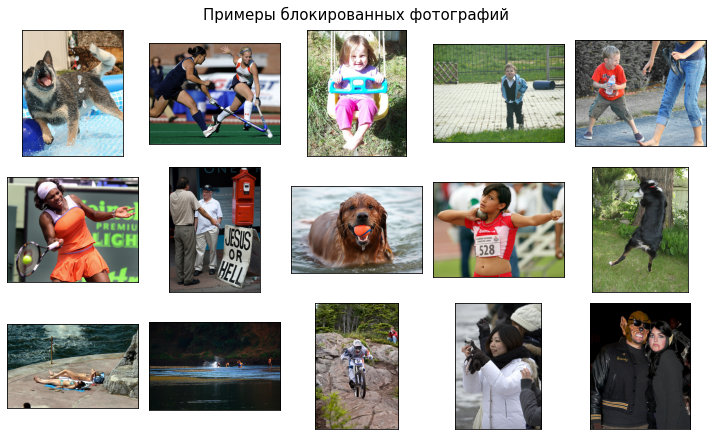

In [68]:
fig = plt.figure(figsize=(10,10))

for i in range(15):
    fig.add_subplot(5, 5, i + 1)
    image = Image.open(Path(DATA_PATH, 'train_images', block_image[i]))
    plt.suptitle('Примеры блокированных фотографий', fontsize = 15)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Исходя из описаний отбор произведен корректно. Исключим из обучающего датасета все блокированные изображения.

In [69]:
df_train.drop(index = df_train[df_train['block'] == 1].index, inplace = True)

In [70]:
df_train.reset_index(inplace = True, drop = True)

Теперь удалим ненужный столбец 'block'

In [73]:
df_train.drop('block', axis = 1, inplace = True)

In [74]:
df_train.head()

image  ...                      lemm_text
0  1056338697_4f7d7ce270.jpg  ...  man sleep blanket city street
1  3187395715_f2940c2b72.jpg  ...  man sleep blanket city street
2   463978865_c87c6ca84c.jpg  ...  man sleep blanket city street
3   488590040_35a3e96c89.jpg  ...  man sleep blanket city street
4   534875358_6ea30d3091.jpg  ...  man sleep blanket city street

[5 rows x 5 columns]

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   score       36125 non-null  float64
 4   lemm_text   36125 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


Очистили обучающий датасет от перечня запрещенных изображений в соответствии с нашим словарем запрещенных слов и описаниями к изображениям.

**Векторизация изображений**

Выделим главные компоненты изображений с помощью сверточных слоев. Ипользуем ResNet-50, посмотрим на слои и исключим полносвязные. При этом загрузим модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [158]:
# Функция загрузчика изображений для обучения.

def load_train():

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = df_train,
        directory = Path(DATA_PATH, 'train_images'),
        x_col = 'image',
        y_col = 'score',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'input',
        seed = SEED,
        shuffle = False)
    
    return train_gen_flow

In [159]:
# Функция создания модели
def create_model():

    backbone = ResNet50(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])
    
    return model

In [160]:
# Функция создания векторов (эмбеддингов)
def emb_images(model, loaded_train):

    predictions = model.predict(loaded_train)
    
    return predictions

In [161]:
%%time
# Функция создания векторов
embeds_images = emb_images(create_model(), load_train())

Found 36125 validated image filenames.


/home/jupyter/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 1101s 974ms/step
CPU times: user 1h 9min 4s, sys: 28.5 s, total: 1h 9min 32s
Wall time: 18min 22s


In [164]:
embeds_images.shape

(36125, 2048)

Эмбеддинги изображений получены: embeds_images

**Векторизация текстов**

Для векторизации тектов используем BERT. Используем трансформер без классифицирующей головы.  
P.s. также пробовал TF-IDF, однако в итоге результат работы модели оказался хуже, при этом использовал 1 н-грамм, при использовании 3-х н-грамм забил всю ОП... В общем, потом дольше, но с лучшим результатом использовал BERT.

In [84]:
df_train.head()

image  ...                      lemm_text
0  1056338697_4f7d7ce270.jpg  ...  man sleep blanket city street
1  3187395715_f2940c2b72.jpg  ...  man sleep blanket city street
2   463978865_c87c6ca84c.jpg  ...  man sleep blanket city street
3   488590040_35a3e96c89.jpg  ...  man sleep blanket city street
4   534875358_6ea30d3091.jpg  ...  man sleep blanket city street

[5 rows x 5 columns]

In [85]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

100%|██████████| 510/510 [00:00<00:00, 187kB/s]
100%|██████████| 414M/414M [00:21<00:00, 20.0MB/s] 


In [192]:
preproc_keras = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [197]:
def vectorize_query(model, data, preprocessor):
    batch_size = 32
    embeddings = []
    tokenized = preprocessor(data)
    for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        
        tokens = tokenized['token_ids'][batch_size * i : batch_size * (i + 1)]
        token_types = tokenized['segment_ids'][batch_size * i : batch_size * (i + 1)]
        mask = tokenized['padding_mask'][batch_size * i : batch_size  *(i + 1)]
        batch = {'token_ids' : tokens, 'segment_ids' : token_types,  'padding_mask' : mask}
        batch_embed = model.predict(batch, verbose = 1)
        embeddings.append(batch_embed['pooled_output'])

    return np.concatenate(embeddings)

Преобразуем наши тексты для подачи в функцию.

In [88]:
text = list(df_train['query_text'])

Запустим получение эмбеддингов

In [ ]:
%%time
text_embeds = vectorize_query(model = bert, data = text, preprocessor = preproc_keras)

2024-04-10 10:46:40.763893: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


  0%|          | 0/1129 [00:00<?, ?it/s]

CPU times: user 19h 32min 33s, sys: 4min 28s, total: 19h 37min 1s
Wall time: 5h 3min 58s


In [ ]:
text_embeds.shape

(36125, 768)

Зафиксируем величину векторов описаний, понадобится в дальнейшем.

In [ ]:
query_vector_size_short = text_embeds.shape[1]
query_vector_size_short

768

**Объединение векторов**

In [165]:
features = np.concatenate((embeds_images, text_embeds), axis=1)

In [166]:
features.shape

(36125, 2816)

In [167]:
# Выделим таргет
target = np.array(df_train['score'])
target.shape

(36125,)

Объединили эмбеддинги, получили признаки и выделили целевой.

Вывод по п.2 "Подготовьте данные к обучению модели":  

- Создали словарь блокирующих слов, включив в него обозначение детей и несовершеннолетних лиц.  
- Чуть меньше 1/3 данных попали под наше правило блокировки.  
- Исключили из обучающего датасета все блокированные изображения.  
- провели Векторизацию изображений.  
 - Выделили главные компоненты изображений с помощью сверточных слоев. Ипользовали архитектуру ResNet-50, посмотрели на слои и исключим полносвязные слои. При этом загрузили модель данной архитектуры, предварительно натренированную на датасете ImageNet.   
 - Эмбеддинги изображений получены размерностью 2048.  
- провели Векторизацию текстов.  
 - Для векторизации тектов использовали BERT (base cased EN). Трансформер без классифицирующей головы.  
 - Размерность полученных векторов изображений в 2 раза больше размерности векторов описаний.  
- Объединили эмбеддинги, получили признаки и выделили целевой.

**Обучение модели предсказания соответствия**

Получим обучающую и тестовую (валидационную) выборки. Сделаем это с помощью GroupShuffleSplit так, чтобы строки с одинаковыми изображениями содержались либо в тестовом (валидационном), либо в тренировочном датасете.

In [168]:
gss = GroupShuffleSplit(n_splits = 1, train_size = .8, random_state = SEED)
train_indices, test_indices = next(gss.split(X = features, y = target, groups = df_train['image']))

In [169]:
train_features, test_features = features[train_indices], features[test_indices]
train_target, test_target = target[train_indices], target[test_indices]

In [170]:
train_features.shape

(28913, 2816)

In [171]:
test_features.shape

(7212, 2816)

In [172]:
train_target.shape

(28913,)

In [173]:
test_target.shape

(7212,)

Применим масштабирование, так как по условию задачи необходимо использовать линейную модель.

In [174]:
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

Выберем метрику, лучшей метрикой, на мой взгляд, будет метрика MAE, можно и RMSE, но за счет возведения в квадрат она будет сильнее реагировать на выбросы. Остановим выбор на средней абсолютной ошибке (MAE).

**LinearRegression**

In [175]:
%%time
model_lr = LinearRegression(n_jobs = -1)
model_lr.fit(train_features, train_target)
predict_lr = model_lr.predict(test_features)

CPU times: user 19.9 s, sys: 2.1 s, total: 22 s
Wall time: 6.75 s


In [176]:
print("Средняя абсолютная ошибка (MAE) на LinearRegression:", mean_absolute_error(test_target, predict_lr))

Средняя абсолютная ошибка (MAE) на LinearSVR: 1668.0034591517347


похоже не нравятся данные для LinearRegression

**Ridge**

In [177]:
%%time
model_rd = Ridge(random_state = SEED)
model_rd.fit(train_features, train_target)
predict_rd = model_rd.predict(test_features)

CPU times: user 43.4 s, sys: 3.99 s, total: 47.4 s
Wall time: 12.6 s


In [178]:
print("Средняя абсолютная ошибка (MAE) на Ridge:", mean_absolute_error(test_target, predict_rd))

Средняя абсолютная ошибка (MAE) на LinearSVR: 0.3632234672071181


**LinearSVR**

In [179]:
model_svr = LinearSVR(random_state = SEED)
param_grid = {'loss':['squared_epsilon_insensitive'], 'C':[1]}
gs_svr = GridSearchCV(model_svr, param_grid, scoring='neg_root_mean_squared_error', n_jobs = -1, cv = 3, verbose = 1)

In [180]:
%time 
gs_svr.fit(train_features, train_target, groups = df_train['image'].loc[train_indices])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [181]:
# на тестовых данных (валидационных)
pred = gs_svr.predict(test_features)

In [182]:
print("Средняя абсолютная ошибка (MAE) на LinearSVR:", mean_absolute_error(test_target, pred))

Средняя абсолютная ошибка (MAE) на LinearSVR: 0.3702811080622216


**NeuralNetwork**

In [183]:
train_features.shape

(28913, 2816)

In [184]:
Neural_Network = Sequential()
Neural_Network.add(Dense(2816, input_shape = (2816,), activation = 'relu'))
Neural_Network.add(BatchNormalization())
Neural_Network.add(Dense(256, activation = 'relu'))
Neural_Network.add(BatchNormalization())
Neural_Network.add(Dense(1, activation = 'relu'))
optimizer = Adam(learning_rate = 1e-4)
Neural_Network.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [tf.keras.metrics.MeanAbsoluteError()])
Neural_Network.build()
Neural_Network.summary()

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 2816)           │     7,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2816)           │        11,264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       721,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,666,369 (33.06 MB)

 Trainable params: 8,660,225 (33.04 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [185]:
Neural_Network.fit(train_features, train_target, validation_data=(test_features, test_target), batch_size=32, epochs=10, verbose=1, shuffle=False)

Epoch 1/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 0.2997 - mean_absolute_error: 0.2764 - val_loss: 0.0558 - val_mean_absolute_error: 0.0914
Epoch 2/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 0.0970 - mean_absolute_error: 0.1422 - val_loss: 0.0559 - val_mean_absolute_error: 0.0897
Epoch 3/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 0.0763 - mean_absolute_error: 0.1247 - val_loss: 0.0566 - val_mean_absolute_error: 0.0938
Epoch 4/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 0.0761 - mean_absolute_error: 0.1236 - val_loss: 0.0554 - val_mean_absolute_error: 0.0884
Epoch 5/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 0.0716 - mean_absolute_error: 0.1196 - val_loss: 0.0561 - val_mean_absolute_error: 0.0893
Epoch 6/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 0.0698 - mean_absolute_error: 0.1183 - val_loss: 0.0554 - val_mean_absolute_error: 0.0884
Epoch 7/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 0.0698 - mean_absolute_err

In [186]:
NN_preds = Neural_Network.predict(test_features)

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [187]:
print("Средняя абсолютная ошибка (MAE) на NeuralNetwork:", mean_absolute_error(test_target, NN_preds))

Средняя абсолютная ошибка (MAE) на NeuralNetwork: 0.09108480674048047


Лучшее значение показала модель NeuralNetwork, протестируем тестовые данные на ней.

**Тестирование**

Для этого получим эмбеддинги для всех тестовых изображений из папки test_images, выберем случайные 10 запросов из файла test_queries.csv и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Получим эмбеддинги для изображений из тестового набора, test_gen_flow был получен еще при знакомстве с набором изображений в начале работы, create_model() была написана при получении эмбеддингов для тренировочного набора. Воспользуемся ими.

In [ ]:
image_embed_test = emb_images(create_model(), test_gen_flow)
image_embed_test.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step


(100, 2048)

In [ ]:
# Функция, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.  
def find_images(text, image_embed_test, preprocessor = preproc_keras):
    # Удалять изначально не будем описания с "блокирующими", по заданию нужен отбойник - реализуем:
    text_lemmatized = get_lemmas(text)
    block_list = [i for i in text_lemmatized if i in BLOCK]
    if block_list:
        print('*'*100)
        print()
        print(text)
        print()
        print('*'*100)
        s = 'This image is unavailable in our country in compliance with local laws'.upper()
        print(f'*** {s} ***')
        print('*'*100)
        print()
    # Если "блокирующих" слов в описании не встретилось:
    else:
        # Получим эмбеддинги для запроса:
        text_embed_test = vectorize_query(model = bert, data = [text], preprocessor = preproc_keras)
        X_test = np.concatenate((image_embed_test, np.resize(text_embed_test, (image_embed_test.shape[0], query_vector_size_short))), axis=1)
        # Также тестировал на TF-IDF, но там результат оказался еще хуже
        #tf_vect_test = TfidfVectorizer(stop_words = stop_words)
        #tf_matrix_test = tf_vect_test.fit_transform([lemm_text(text)])
        #image_embed_test = pd.DataFrame(image_embed_test)
        #text_embed_test = pd.DataFrame(tf_matrix_test.todense())
        #X_test = np.concatenate((image_embed_test, np.resize(text_embed_test, (image_embed_test.shape[0], query_vector_size_short))), axis=1)
        # Применим масштабирование
        X_test_scaled = scaler.transform(X_test)
        # Получим предсказания на выбранной нами NeuralNetwork
        predictions = Neural_Network.predict(X_test_scaled)
        # добавляем оценки к номерам картинок
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name = 'pred')), axis = 1)
        # Получим топ 5 названий файлов с изображениями
        top_5 = list(df.sort_values(by = 'pred', ascending = False)['image'].head())
        # Получим топ 5 оценок
        top_5_score = list(df.sort_values(by = 'pred', ascending = False)['pred'].head())
        print()
        print(text)
        print()
        
        fig = plt.figure(figsize=(15,5)) 
        # Подсветим синей окантовкой выводимые нашей моделью изображения
        plt.rcParams['axes.edgecolor'] = 'blue'
        plt.rcParams['axes.linewidth'] = 5
        # Выведем на экран 5 наиболее похожих картинок
        for i in range(5):
            fig.add_subplot(1, 6, i + 1, title = round(top_5_score[i], 2))
            image = Image.open(Path(DATA_PATH, 'test_images', top_5[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        # если текст был в исходном файле с описаниями - добавляем оригинальную картинку
        if text in list(df_queries['query_text']): 
            # Подсветим красной окантовкой
            plt.rcParams['axes.edgecolor'] = 'red'
            plt.rcParams['axes.linewidth'] = 10
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(DATA_PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

        print('-'*100)
    return None

In [ ]:
# Формирование 10 произвольных запросов
test_phrases = df_queries.sample(10)
test_phrases = list(test_phrases['query_text'])
test_phrases

['A sad looking dog sitting next to shrubs .',
 'An ice skating park in winter , with many people .',
 'A man is operating a television camera high up in a crowded stadium .',
 'Man wearing hat and t-shirt with " Genetic Freak " sleeping on public transportation .',
 'A young boy is holding a PlayStation controller over his head .',
 'The brown dog is wearing a black collar .',
 'A watercraft speeds through the water .',
 'Black men in poor neighborhood .',
 'A man wearing glasses and black clothing is sitting while a man in a vest drinks in the background .',
 'A white dog runs on brown grass .']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

A sad looking dog sitting next to shrubs .



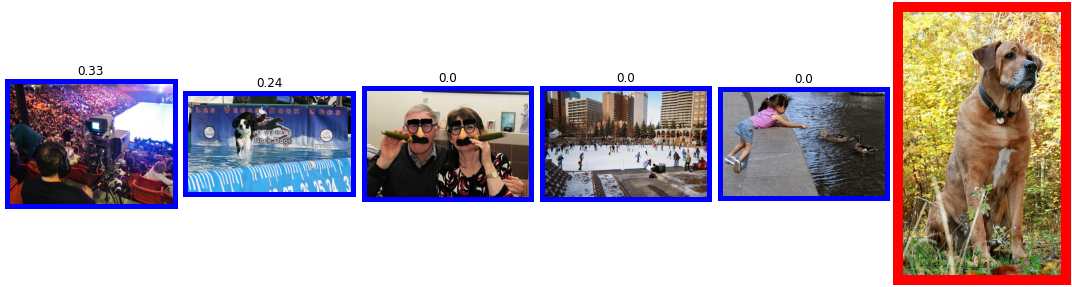

----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

An ice skating park in winter , with many people .



----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

A man is operating a television camera high up in a crowded stadium .



----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Man wearing hat and t-shirt with " Genetic Freak " sleeping on public transportation .



----------------------------------------------------------------------------------------------------
****************************************************************************************************

A young boy is holding a PlayStation controller over his head .

****************************************************************************************************
*** THIS IMAGE IS UNAVAILABLE IN OUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ***
****************************************************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

The brown dog is wearing a black collar .



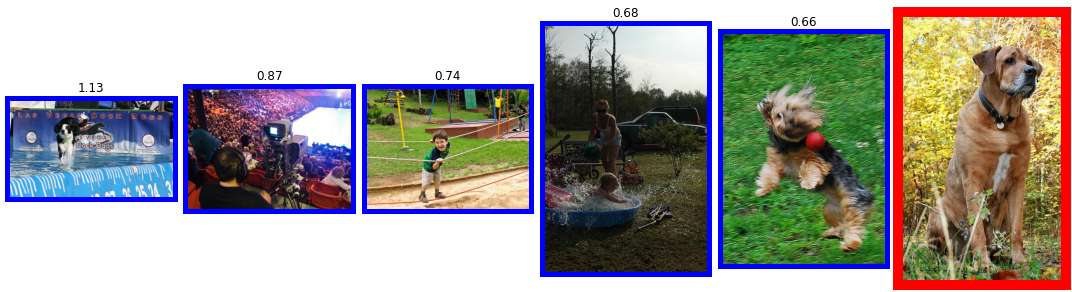

----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

A watercraft speeds through the water .



----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Black men in poor neighborhood .



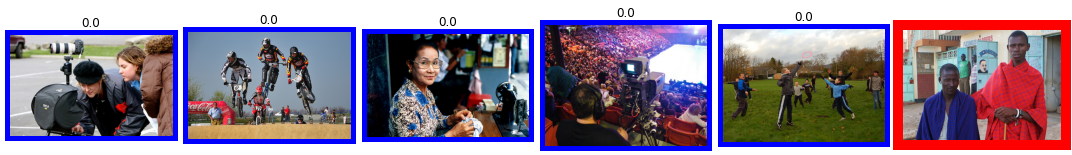

----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

A man wearing glasses and black clothing is sitting while a man in a vest drinks in the background .



----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

A white dog runs on brown grass .



----------------------------------------------------------------------------------------------------


In [ ]:
# Для каждого запроса вызовем функцию find_images
for i in test_phrases:
    find_images(i, image_embed_test)

Вывод:  

Провели исследовательский анализ данных, агрегировали оценки толпы и экспертов:  
- Итоговую оценку соответствия изображения описанию масштабировали в значения [0, 1]: 0 - не соответсвует, 1 - полностью соответсвует;  
- Больше доверия к экспертным оценкам, если экспертных оценок нет, прибегаем к помощи толпы;  
- Выбрали метод и аггрегировали оценки;   
- Объединили оценки с обучающим набором данных, заполнили пропущенные описания посредством данных столбца query_id;  
- По итогу заполнения описаний удалили те записи, которые заполнить не удалось, их было немного.  

Подготовили данные к обучению моделей:  
- Создали словарь 'блокирующих' слов, включив в него обозначение несовершеннолетних лиц. Для избавления от нелегального контента использовали текстовые описания к изображениям.
- Чуть меньше 1/3 данных попали под наше правило блокировки.  
- Исключили из обучающего датасета все блокированные изображения.  
- провели Векторизацию изображений.  
 - Выделили главные компоненты изображений с помощью сверточных слоев. Ипользовали архитектуру ResNet-50, посмотрели на слои и исключили полносвязные. При этом загрузили модель данной архитектуры, предварительно натренированную на датасете ImageNet.   
 - Эмбеддинги изображений получены размерностью 2048.  
- провели Векторизацию текстов.  
 - Для векторизации тектов использовали BERT (base cased EN). Трансформер без классифицирующей головы. P.s. также пробовал TF-IDF, однако в итоге результат работы модели оказался хуже, при этом использовал 1 н-грамм, при использовании 3-х н-грамм забил всю ОП... В общем, потом дольше, но с лучшим результатом использовал BERT.
 - Размерность полученных векторов изображений в 2 раза больше размерности векторов описаний.  
- Объединили эмбеддинги, получили признаки и выделили целевой.

Обучили 4 модели:
- LinearRegression;  
- LinearSVR;  
- Ridge;  
- NeuralNetwork.  

Лучше всего себя показала NeuralNetwork, с ней мы провели проверку на наборе тестовых изображений.  
Результат оказался, на мой взгляд, неудовлетворительным. Лишь в некоторых случаях в топ 5 выдачи изображений попадало верное.